# Segundo Parcial - Aprendizaje Automático UNSAM

> Esta vez entrego sin una linea de R (?)

### 1er cuatrimestre de 2021

## Ejercicio 1. Clasificación y modelos de ensemble

### 1.a Simulate data

**a.** Utilice la función `make_moons` del paquete `sklearn.datasets` para generar un dataset artificial de clasificación binaria de 5000 elementos (2500 de cada clase). Use un ruido de 0.15 (`noise=0.15`)

*Nota*: fije un valor de `random_state` para poder repoducir el resultado.

Separe 20% de los datos generados para utilizar como conjunto de testeo. Asegúrese que las clases están correctamente representadas en ambos conjuntos.

In [1]:
from sklearn.datasets import make_moons

random_state = 666

In [2]:
X, t = make_moons(n_samples=5000, noise=0.15, random_state=random_state)

t.sum() # cantidad de "1" == 5000/2 si está balanceado

2500

https://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html

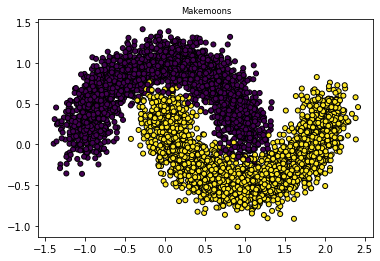

In [3]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles


plt.title("Makemoons", fontsize='small')
plt.scatter(x=X[:,0], y=X[:,1], marker='o', c=t, s=25, edgecolor='k')
plt.show()

https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/

https://stackoverflow.com/a/54601017

In [4]:
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=0.2, random_state=random_state, stratify=t)

In [5]:
print(y_train.shape)
print(y_train.sum())
print(y_test.shape)
print(y_test.sum())

(4000,)
2000
(1000,)
500


In [6]:
# ?make_moons
# ?plt.scatter

### 1.b Plot data

**b.** Grafique los datos coloreando de manera diferente cada clase. Discuta sobre la separabilidad de los datos. ¿Qué tipo de algoritmos no prometen ser muy útiles en este caso?

Respuestas:

- Grafico hecho arriba.
- Los datos no son "linealmente" separables porque ninguna recta en el espacio de los datos puede separar las clases completamente (sin error). Eso se ve por la forma de lunas enganchadas que tiene distribucion de los datos.
  - Además, hay regiones con datos de una clase que se "meten" en la distirbución de la otra, entonces las distribuciones no son separables por una recta en ninguna transformación "simple" de los datos. Cualquier separación va a tener error.
- Los algoritmos que dependan de armar una recta de decision en el espacio de los datos no van a funcionar bien: al menos el perceptrón y el maximum margin classifier.

### 1.c DT

**c.** *Árbol de decisión*. Entrene un árbol de decisión para clasificar los datos:
* Use validación cruzada para encontrar los hiperparámetros óptimos del árbol de decisión (sea criteriose acerca de qué hiperparámetros se modifican. **Justifique**). 
  * CV no dio el mejor resultado y elegí un `ccp_alpha` a ojo (ver discusión más abajo).
* Evalue la performance con las métricas que encuentre útiles (y sin usar el conjunto de test)
  * Accuracy viene bien para clases balanceadas.
* Use la función que se provee a continuación para graficar las regiones de decisión. 
  * La cambié un poquito porque no habia contraste entre los puntos y las regiones.

In [6]:
import numpy as np

def plot_regiones(X, t, modelo, nmesh=200, cmap='Greys', cmap_scatter='Set1', figsize=(20, 10),main = None):
    """
    X: matriz de los features con dimensión (n_datos, n_features)
    t: labels del conjunto de datos (n_datos,)
    modelo: modelo usado para la clasificación.
    
    nmesh: número de puntos en cada dimensión para plotear
    cmap: determina la escala de colores que se usa para el gráfico
    """
    
    plt.figure(figsize=figsize)

    # Define le grilla para el gráfico
    xx1, xx2 = np.meshgrid(np.linspace(X[:, 0].min()-0.2, X[:, 0].max()+0.2, nmesh), 
                           np.linspace(X[:, 1].min()-0.2, X[:, 1].max()+0.2, nmesh))

    # Evalúa la predicción del modelo para cada uno de los puntos de la grilla.
    Y = modelo.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Y = Y.reshape(xx1.shape)

    # veamos la función de decisión y la frontera de decisión
    plt.pcolormesh(xx1, xx2, Y, cmap=cmap)

    if '_r' in cmap_scatter:
        cmapr = cmap_scatter[:-2]
    else:
        cmapr = cmap_scatter+'_r'
    #
    plt.scatter(*X.T, c=t, s=4, cmap=cmapr)

    if main is not None:
      plt.title(main)
    
    return

Primero miro como queda sin restricciones:

* Tiene profundidad ~12.
* Overfittea armando regioncitas finitas y/o para pocos datos.
* Parece que tiene sentido limitar la profunidad del escaneo a 12 y que genere hojas con mas de 5 datos.


In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dt = tree.DecisionTreeClassifier()
dt.fit(X_train,y_train)

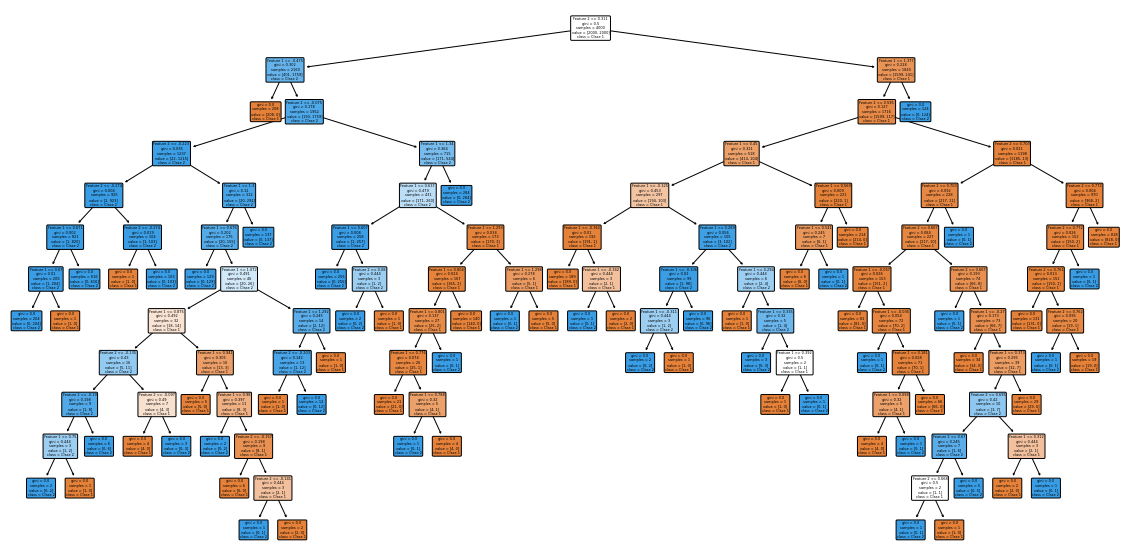

In [9]:
plt.figure(figsize=(20,10))
tree.plot_tree(dt,filled=True,rounded=True,feature_names=["Feature 1","Feature 2"],class_names=["Clase 1","Clase 2"]) 
plt.show()

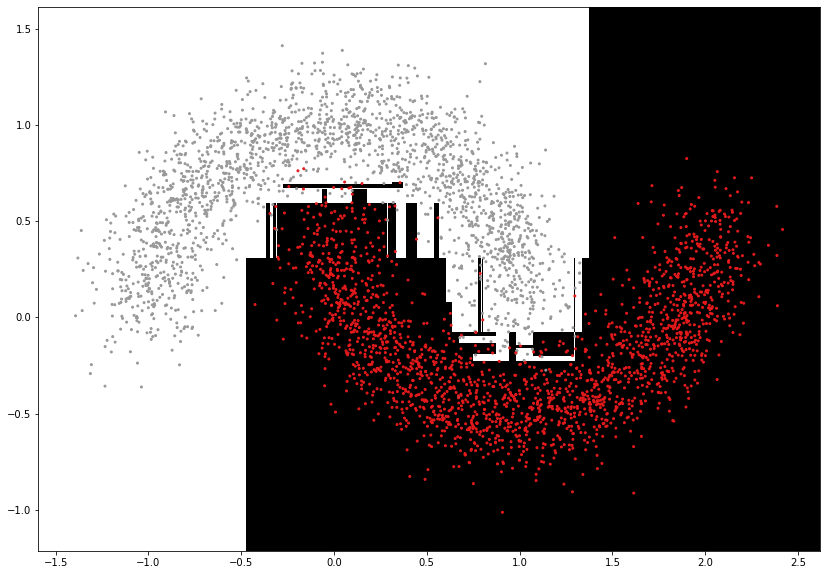

In [13]:
plot_regiones(X_train, y_train, dt, figsize=(14, 10), nmesh=1000)


> _wingardium leviosa!_

In [14]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(1,12), 'min_samples_leaf':range(3,20)}

dt = tree.DecisionTreeClassifier()

clf = GridSearchCV(dt, parameters, n_jobs=4, scoring='accuracy')

clf.fit(X=X_train, y=y_train)

tree_model = clf.best_estimator_

print(clf.best_score_)
print(clf.best_params_) 

0.9889999999999999
{'max_depth': 10, 'min_samples_leaf': 4}


Al principio CV eligió `min_samples_leaf=5` así que permití hasta 3,y eligió 4.


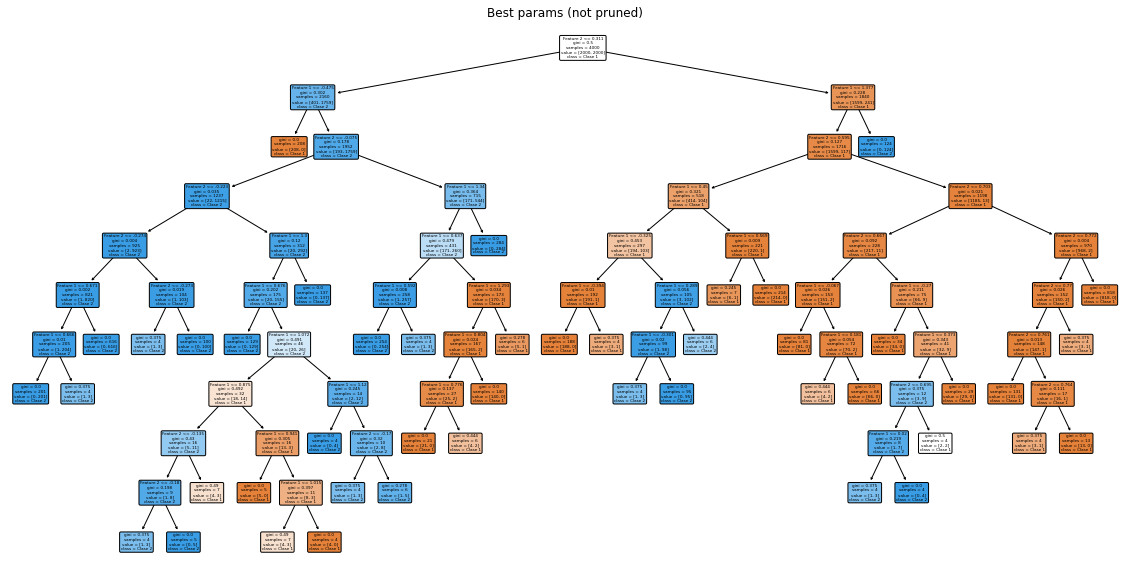

In [15]:
plt.figure(figsize=(20,10))
tree.plot_tree(tree_model,filled=True,rounded=True,feature_names=["Feature 1","Feature 2"],class_names=["Clase 1","Clase 2"])
plt.title("Best params (not pruned)") 
plt.show()

In [16]:
# from sklearn.metrics import precision_score, recall_score
# from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error 


https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

La poda de invierno:

Text(0.5, 1.0, 'Best params (not pruned) \n Total Impurity vs effective alpha for training set')

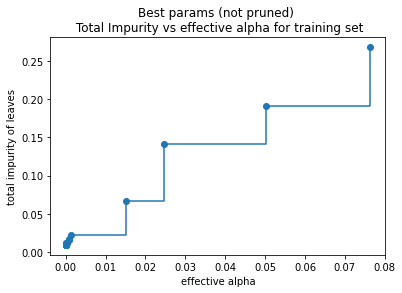

In [17]:
path = tree_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Best params (not pruned) \n Total Impurity vs effective alpha for training set")

Elijo un alpha  con CV y a mano:

In [18]:
from sklearn.metrics import accuracy_score

dt2 = tree.DecisionTreeClassifier(ccp_alpha=0.01)

dt2.fit(X=X_train, y=y_train)

accuracy_score(y_train, dt2.predict(X_train))

0.989

In [19]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

parameters = {'ccp_alpha': np.linspace(0, 0.02, 100)}

dt3 = tree.DecisionTreeClassifier()

clf3 = GridSearchCV(dt3, parameters, n_jobs=4, scoring='accuracy')

clf3.fit(X=X_train, y=y_train)

tree_model3 = clf3.best_estimator_

print(clf3.best_score_)
print(clf3.best_params_) 

0.9872500000000001
{'ccp_alpha': 0.00040404040404040404}


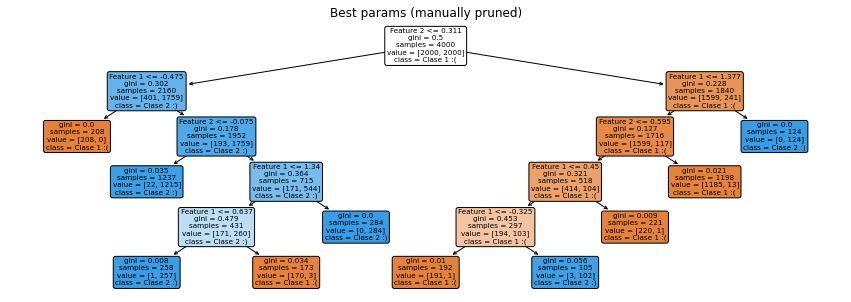

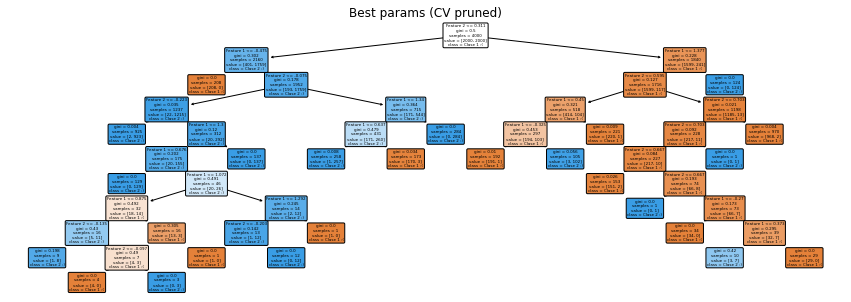

In [22]:
plt.figure(figsize=(15,5))
tree.plot_tree(dt2,filled=True,rounded=True,feature_names=["Feature 1","Feature 2"],class_names=["Clase 1 :(","Clase 2 :)"]) 
plt.title("Best params (manually pruned)") 
plt.show()

plt.figure(figsize=(15,5))
tree.plot_tree(tree_model3,filled=True,rounded=True,feature_names=["Feature 1","Feature 2"],class_names=["Clase 1 :(","Clase 2 :)"]) 
plt.title("Best params (CV pruned)") 
plt.show()

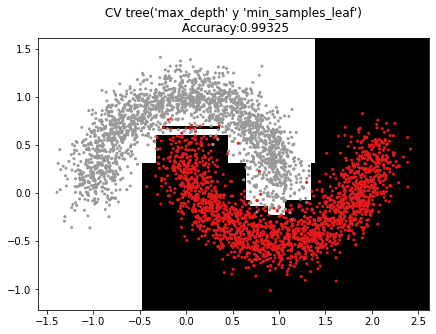

In [27]:
# print(accuracy_score(y_train, tree_model.predict(X_train)))
plot_regiones(X_train, y_train, tree_model, figsize=(7, 5), cmap='Greys', cmap_scatter="Set1", 
              main="CV tree" + "('max_depth' y 'min_samples_leaf')" + "\n Accuracy:" + str(accuracy_score(y_train, tree_model.predict(X_train))))

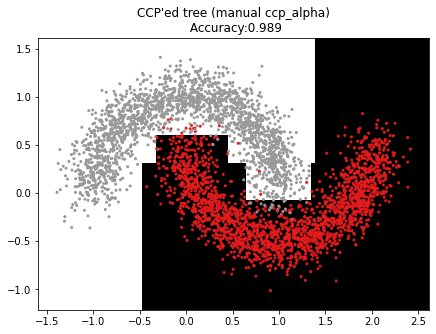

In [28]:
# print(accuracy_score(y_train, dt2.predict(X_train)))
plot_regiones(X_train, y_train, dt2, figsize=(7, 5), cmap='Greys', cmap_scatter="Set1", 
              main="CCP'ed tree (manual ccp_alpha)" + "\n Accuracy:" + str(accuracy_score(y_train, dt2.predict(X_train))) )

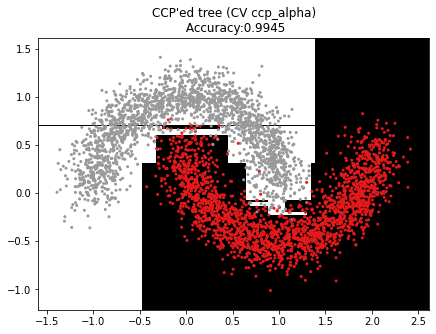

In [29]:
# print(accuracy_score(y_train, tree_model3.predict(X_train)))
plot_regiones(X_train, y_train, tree_model3, figsize=(7, 5), cmap='Greys', cmap_scatter="Set1", 
              main="CCP'ed tree (CV ccp_alpha)" + "\n Accuracy:" + str(accuracy_score(y_train, tree_model3.predict(X_train))))

Curiosamente el "Cost complexity pruning" con CV overfittea.

El `ccp_alpha` que elegí "manualmente" (mirando el plot alpha vs. impurity) parece mejor!

### 1.d SVM

**d.** _Support Vector Machine_. Repita los puntos de arriba utilizando un Support Vector Machine con un kernel de su elección.

* Use validación cruzada para encontrar los hiperparámetros óptimos del árbol de decisión (sea criteriose acerca de qué hiperparámetros se modifican. **Justifique**). 
* Evalue la performance con las métricas que encuentre útiles (y sin usar el conjunto de test)
* Use la función que se provee a continuación para graficar las regiones de decisión. 
* Compare los resultados con DT.

10_SVM.ipynb

In [60]:
def plot_svm(svc, x, t):

    plt.figure(figsize=(9, 7))

    xx, yy = np.meshgrid(np.linspace(x[:, 0].min()-1, x[:, 0].max()+1, 200), 
                         np.linspace(x[:, 1].min()-1, x[:, 1].max()+1, 200))

    # evaluate decision function
    Z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # veamos la función de decisión y la frontera de decisión
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu_r)
    plt.contour(xx, yy, -Z, 0, colors='0.5', zorder=1)
    plt.contour(xx, yy, -Z, [-1, 1], colors='0.25', linestyles='dashed', zorder=1)

    xc1 = x[t == np.unique(t.flatten()).max()]
    xc2 = x[t == np.unique(t.flatten()).min()]

    plt.plot(*xc1.T, 'ob', mfc='None', label='C1')
    plt.plot(*xc2.T, 'or', mfc='None', label='C2')

    # Get suppor vector
    xsv = svc.support_vectors_
    plt.plot(xsv[:, 0], xsv[:, 1], 'o', ms=12, mfc='None', mec='k', mew=2)

    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

    return


Los parametros C y gamma del kernel RBF deben encontrarse por CV.

Se escanea un espacio exponencial, a priori no se sabe en que "escala" van a estar los óptimos.

In [136]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV  #, RandomizedSearchCV

svc_rbf = SVC(kernel='rbf')

params = {'C': np.logspace(-2, 3, 10), 'gamma': np.logspace(-2, 3, 10)}

gscv = GridSearchCV(svc_rbf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)

gscv.fit(X_train, y_train)

print(gscv.best_params_, gscv.best_score_)

{'C': 21.544346900318846, 'gamma': 0.464158883361278} 0.9894999999999999


Muy bonito quedó:

0.98975


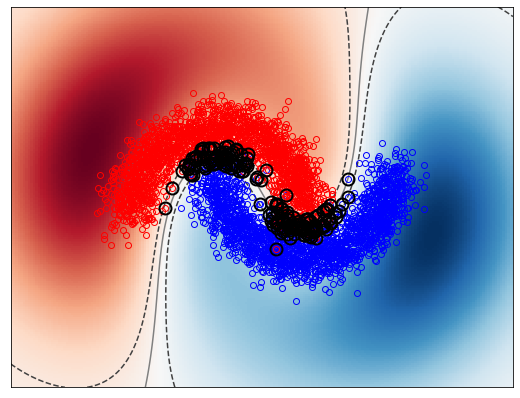

In [139]:
print(accuracy_score(y_train,gscv.predict(X_train)))

plot_svm(gscv.best_estimator_, X_train, y_train)

El accuracy es parecido al del DT podado con `ccp_alpha` elegido a ojo.

Me gusta, parece que capturó bien la forma de la frontera.

### 1.e RF

**e.** Entrene ahora un Random Forest. Repita los puntos de arriba. Compare los resultados.

* Use validación cruzada para encontrar los hiperparámetros óptimos del árbol de decisión (sea criteriose acerca de qué hiperparámetros se modifican. **Justifique**). 
* Evalue la performance con las métricas que encuentre útiles (y sin usar el conjunto de test)
* Use la función que se provee a continuación para graficar las regiones de decisión. 
* Compare los resultados con DT y SVC.

In [143]:
def plot_decision_regions(clf, X, t, axes=None, npointsgrid=500, legend=False, 
                          plot_training=True, 
                          figkwargs={'figsize': [12, 8]}, 
                          contourkwargs={'alpha':0.3}):
    """
    Plot decision regions produced by classifier.

    :param Classifier clf: sklearn classifier supporting XXX
    """

    fig = plt.figure(**figkwargs)
    ax = fig.add_subplot(111)

    if axes is None:
        dx = X[:, 0].max() - X[:, 0].min()
        dy = X[:, 1].max() - X[:, 1].min()
        axes = [X[:, 0].min() - 0.1*dx, X[:, 0].max() + 0.1*dx, 
                X[:, 1].min() - 0.1*dy, X[:, 1].max() + 0.1*dy]
        
    # Define grid for regions
    x1s = np.linspace(axes[0], axes[1], npointsgrid)
    x2s = np.linspace(axes[2], axes[3], npointsgrid)
    x1, x2 = np.meshgrid(x1s, x2s)

    # Make predictions on points of grid; reshape to grid format
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    #custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    ax.contourf(x1, x2, y_pred, **contourkwargs)

    #custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    #plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)

    if plot_training:
        for label in np.unique(t):
            ax.plot(X[:, 0][t==label], X[:, 1][t==label], "o", label="C{}".format(label))

    # Axis
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

    if legend:
        plt.legend(loc="lower right", fontsize=14)

    plt.show()
    return fig


In [164]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

params = {"n_estimators": [20,50,80,120], "max_depth": range(2,12)}

gsrfc = GridSearchCV(rfc, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)

gsrfc.fit(X_train, y_train)

print(gsrfc.best_params_)

{'max_depth': 10, 'n_estimators': 120}


0.9894999999999999


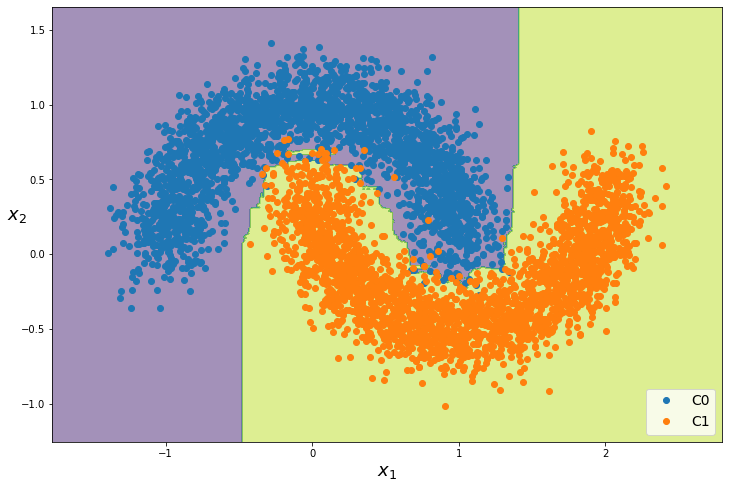

In [165]:
print(gsrfc.best_score_)

fig = plot_decision_regions(gsrfc.best_estimator_, X_train, y_train, legend=True, npointsgrid=500, 
                            figkwargs={'figsize': [12, 8]}, 
                            contourkwargs={'alpha':0.5, 'levels':5, 'cmap':'viridis'})

IMO, el incremento en accuracy respecto a los anteriores es solo overfitting.

Intuyo que no vale la pena usar RF con este dataset.

El DT overfitteo menos y el SVC además capturó bien la forma de la frontera.

### 1.f Otro ensemble

**f.** Elija y entrene otro método de ensamble (que no sea de Boosting) para clasificar los datos, usando el o los clasificadores de base que le resulten más adecuados (puede utilizar Decision Trees y SVMs). Repita lo de arriba.



Bueno ya que dije que los árboles no sirven para este dataset xD, no me queda otra que usar SVMs.

> [This](https://stackoverflow.com/a/47570754) doesn't seem to be documented anywhere


In [178]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(base_estimator=SVC())

params = {'max_samples': [0.05,0.1,0.2], 'n_estimators': [20,50,100], 
          'base_estimator__C': [15.0, 21.5, 30.0], 'base_estimator__gamma': [0.1, 0.464, 1.0]}

gsbag = GridSearchCV(bag, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)

gsbag.fit(X_train, y_train)

print(gsbag.best_params_)

{'base_estimator__C': 15.0, 'base_estimator__gamma': 1.0, 'max_samples': 0.2, 'n_estimators': 100}


0.9887499999999999


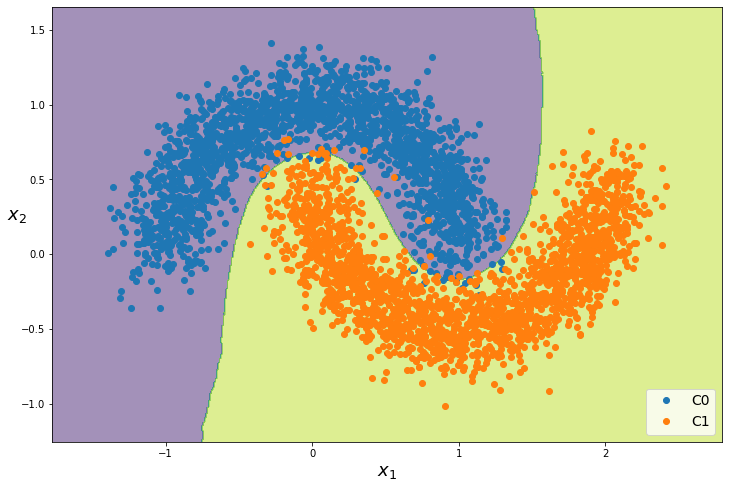

In [180]:
print(gsbag.best_score_)

fig = plot_decision_regions(gsbag.best_estimator_, X_train, y_train, legend=True, npointsgrid=500, 
                            figkwargs={'figsize': [12, 8]}, 
                            contourkwargs={'alpha':0.5, 'levels':5, 'cmap':'viridis'})

EL SVC de antes para comparar:

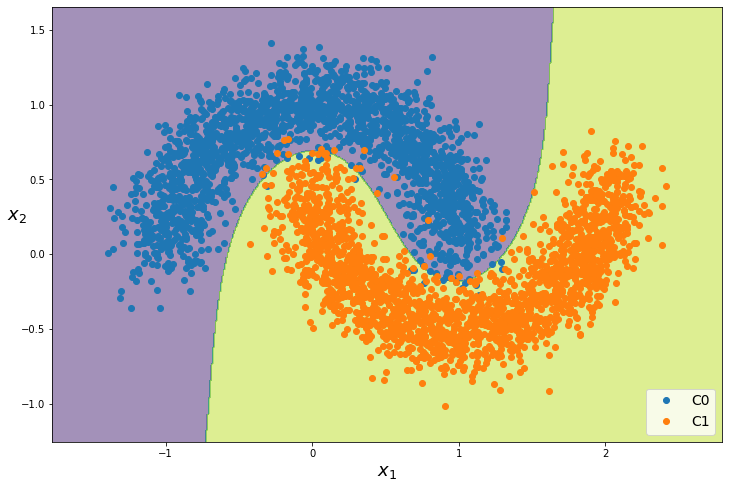

In [181]:
fig = plot_decision_regions(gscv.best_estimator_, X_train, y_train, legend=True, npointsgrid=500, 
                            figkwargs={'figsize': [12, 8]}, 
                            contourkwargs={'alpha':0.5, 'levels':5, 'cmap':'viridis'})

### 1.g Elegir un modelo

**g.** En base a sus resultados:

* Elija uno de los tres algoritmos desarrollados y evalue su performance en el conjunto de test.
* Ahora haga trampa y evalue los otros dos en el conjunto de test también. 
* Discuta los resultados.

In [186]:
print("DT train: " + str(accuracy_score(y_train, dt2.predict(X_train))))
print("SVC train: " + str(accuracy_score(y_train,gscv.predict(X_train))))
print("RFC train: " + str(accuracy_score(y_train,gsrfc.best_estimator_.predict(X_train))))
print("")
print("DT test: " + str(accuracy_score(y_test, dt2.predict(X_test))))
print("SVC test: " + str(accuracy_score(y_test,gscv.predict(X_test))))
print("RFC test: " + str(accuracy_score(y_test,gsrfc.best_estimator_.predict(X_test))))

DT train: 0.989
SVC train: 0.98975
RFC train: 0.9995

DT test: 0.99
SVC test: 0.997
RFC test: 0.993


En train, "ganaba" el RFC, pero en test es mejor el SVC.

Todo por muy poco.

Como el RFC bajó su accuracy en test, confirma que estaba sobreajustando.

En cambio el SVC (y el DT también) aumentó el accuracy en test respecto a train.

Otra vez, todo por muy poco.



Probablemente esta diferencia se hubiera manifestado más en un dataset más ruidoso.

Es fácil clasificar bien la mayor parte de los puntos con el ruido (bajo) de la consigna.

**h. Optativo por la gloria:** Entrene y optimice un GradientBoosting y compare con los resultados previos. 

In [30]:
pass

## Ejercicio 2: Aprendizaje Profundo

En el siguiente ejercicio trabaje con una porción del conjunto de datos SIGNS creado por [deeplearning.ai](http://deeplearning.ai) para una de sus especializaciones. El dataset consiste en fotos de manos haciendo la señal correspondiente a algún número entre el cero y el cinco en lenguaje internacional de señas.

El objetivo es entrenar un algoritmo que identifique a partir de una foto de qué número se trata.

### Cargar datos

In [ ]:
import sys

!wget https://github.com/IAI-UNSAM/datasets/raw/master/parcial2_2_2020/train_signs.h5
!wget https://github.com/IAI-UNSAM/datasets/raw/master/parcial2_2_2020/test_signs.h5


En la siguiente celda hemos cargado una función que carga los datos:

In [10]:
import h5py
import numpy as np

def load_dataset(path=''):
    train_dataset = h5py.File(path+'train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path+'test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

X_train_full, y_train_full, X_test, y_test, classes = load_dataset()
y_train_full = y_train_full.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("Lectura completa")

Lectura completa


In [11]:
classes

array([0, 1, 2, 3, 4, 5])

### Train-Validation-Test split & Escalado

In [12]:
val_frac = 0.2
val_n = int(np.floor(X_train_full.shape[0] * val_frac))
val_n

216

In [13]:
X_valid, X_train = X_train_full[:val_n] / 255.0, X_train_full[val_n:] / 255.0
y_valid, y_train = y_train_full[:val_n], y_train_full[val_n:]

X_test = X_test / 255.0
# y_test queda tal cual

X_valid.shape

(216, 64, 64, 3)

Graficar muestra de los datos (train):

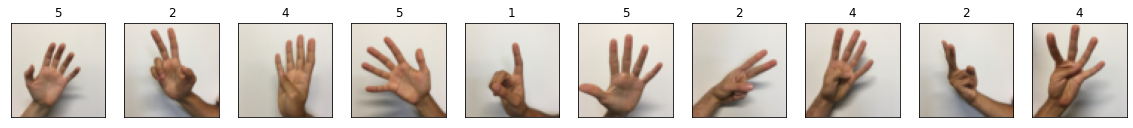

In [14]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title(str(y_train[i,0]))
    plt.imshow(X_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 2.a Entrenar ANNs

**a**. Se pide entrenar una red de tipo *fully connected* y una red *convolucional*. Teniendo en cuenta los datos:
  * Discuta y explique las ventajas y desventajas de cada una.
    * Una red densa en teoría puede resolver cualquier problema, pero esmás difícil de entrenar (más parámetros, más problemas).
    * Una estructura tipo CNN sirve para clasificar datos que son de alguna manera "espaciales" (como una imagen). Como el mismo kernel se comparte en toda la capa, tienen muchos menos parámetros para entrenar.
  * ¿Con cuál espera alcanzar una mejor *performance*? ¿Por qué?
    * En teoría una CNN es más fácil de entrenar para clasificar imágenes. En ese sentido debería salir mejor/más fácil que una densa.
     Quizás la densa deberia aprender que diferentes partes de la imagen _flatteneada_ son 3 colores diferentes de una misma posición. Seguro puede pero no hace falta darle esa _libertad_. La CNN no tiene ese problema.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
import tensorflow as tf
from tensorflow import keras

https://colab.research.google.com/notebooks/gpu.ipynb

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#### Definir modelo DNN


In [24]:
# Limpiar sesión antes

tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Nota: las layers de dropout no cambiaron demasiado el resultado y las dejé afuera.

In [25]:
n_units = 512

input_layer = keras.layers.Input(shape=X_train.shape[1:])

flatten = keras.layers.Flatten(input_shape=(64,64,3))(input_layer)

hidden1 = keras.layers.Dense(n_units, activation="relu")(flatten)

# drop1 = keras.layers.Dropout(rate=0.1)(hidden1)

hidden2 = keras.layers.Dense(n_units/2, activation="relu")(hidden1)

# drop2 = keras.layers.Dropout(rate=0.1)(hidden2)

# hidden3 = keras.layers.Dense(n_units/4, activation="relu")(drop2)

output = keras.layers.Dense(classes.shape[0], activation="softmax")(hidden2)

model = keras.models.Model(inputs=[input_layer], outputs=[output])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               6291968   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 6,424,838
Trainable params: 6,424,838
Non-trainable params: 0
_________________________________________________________________


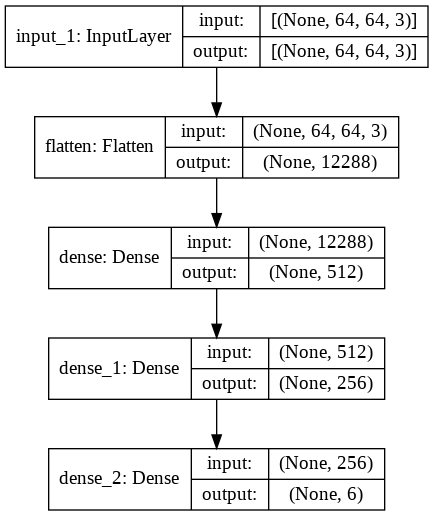

In [26]:
keras.utils.plot_model(model, "fc_model.png", show_shapes=True)

In [27]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, verbose=1,
                                                  restore_best_weights=True)

#### Fittear

In [28]:
batch_size = 32
epochs = 200

history = model.fit(X_train, y_train[:,0], 
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid[:,0]),
                    callbacks=[early_stopping_cb],
                    verbose=1)

Epoch 1/200
27/27 [==============================] - 2s 52ms/step - loss: 5.4250 - accuracy: 0.1968 - val_loss: 2.0364 - val_accuracy: 0.1898
Epoch 2/200
27/27 [==============================] - 1s 46ms/step - loss: 2.0227 - accuracy: 0.2419 - val_loss: 1.7651 - val_accuracy: 0.2361
Epoch 3/200
27/27 [==============================] - 1s 45ms/step - loss: 1.7412 - accuracy: 0.2928 - val_loss: 1.5708 - val_accuracy: 0.3889
Epoch 4/200
27/27 [==============================] - 1s 46ms/step - loss: 1.5546 - accuracy: 0.3924 - val_loss: 1.6370 - val_accuracy: 0.4167
Epoch 5/200
27/27 [==============================] - 1s 52ms/step - loss: 1.3733 - accuracy: 0.4456 - val_loss: 1.9677 - val_accuracy: 0.2269
Epoch 6/200
27/27 [==============================] - 1s 45ms/step - loss: 1.3609 - accuracy: 0.4780 - val_loss: 1.5626 - val_accuracy: 0.5000
Epoch 7/200
27/27 [==============================] - 1s 44ms/step - loss: 1.6074 - accuracy: 0.4109 - val_loss: 1.3285 - val_accuracy: 0.4676
Epoch 

#### Revisar resultados

16_ANNs_part2.ipynb

In [29]:
early_stopping_cb.stopped_epoch

87

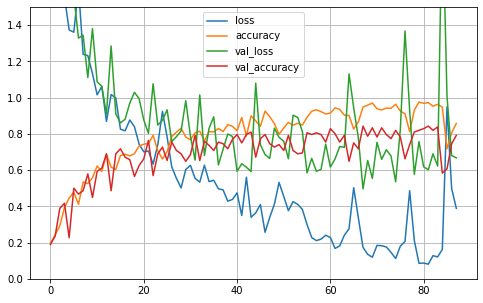

In [30]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

Muy ruidoso la verdad. Podría probar bajando el learning rate.

#### Guardar modelo

In [31]:
# model.save("dnn2_keras_model.h5")
# model.save_weights("dnn2_keras_model.ckpt")

### 2.b Exploración y preparación de datos

**b. Exploración y preparación de datos**

*  ¿Qué shape tienen los datos? ¿Cuántas muestras hay? ¿Qué rango de valores tiene cada pixel?
  * Hay 1080 muestras en el dataset de entrenamiento.
  * Ver celdas:


In [18]:
# 1080 imagenes de 64x64 pixeles y 3 canales
print(X_train_full.shape)

(1080, 64, 64, 3)


In [19]:
# minimo y máximo de los pixeles
print(X_train_full.min(), X_train_full.max())

4 244



*  Normalice los datos apropiadamente para entrenar usando una red neuronal.
  * Los datos fueron normalizados (escalados) más arriba: de 0-255 a 0.0-1.0


*  Separe del conjunto de entrenamiento un 20% de los datos para utilizar como datos de validación.
  * Los datos fueron separados en train y validation con esa fracción.


In [20]:
# Ver definición más arriba
val_frac

0.2

**Nota**: En los próximos pasos, se pide construir dos redes neuronales artificiales. Recomendamos empezar con arquitecturas simples y asegurarse de que el modelo funciona antes de intentar optimizarla para mejorar la performance.

### 2.c Construcción de la Red Densa

Construir una red densa usando `keras` que contenga al menos dos capas ocultas. Se puede usar la API funcional o la secuencial.

Algunas pistas (no para contestar, pero para tener en cuenta):

* ¿Qué tipo de capa se necesita para conectar los datos con el resto de la red?
  * Flatten
* Además de elegir el número de unidades de cada capa, ¿qué otros parámetros tenemos que definir?
  * Función de activación
  * Hay varias opciones: método de regularización, inicializador de pesos, [etc](https://keras.io/api/layers/core_layers/dense/).
* ¿La capa de salida tiene que tener un número de unidades específico? ¿Y la función de activación?
  * Si, la capa de salida tiene que tener un número de unidades igual al número de clases.
  * La función de activación debería dar un número entre 0 y 1 para cada clase, de forma que se parezca a una "probabilidad".
* ¿Qué tipo de capas puede intercalar entre capas ocultas para mejorar la generalización de la red?
  * Dropout: para desactivar algunas neuronas aleatoriamente en cada paso de entrenamiento.

*Por motivos de reproducibilidad, pedimos dejar el siguiente random seed antes de entrenar*

In [21]:
# Por suerte usé seed 42 arriba :)



> *Don't panic!*

### 2.d Compilación

* ¿Cuál es la función de costo apropiada para este problema?
  * Como le pasé un vector con las clases, es la "sparse categorical cross-entropy".
* Compilar el modelo utilizando el optimizador ``adam``.  Agregar ``accuracy`` como métrica a monitorear.
  * :ok:

### 2.e Entrenar una CNN

**e. Entrenamiento**

* Entrenar el modelo por al menos 50 epocas, con un tamaño de batch de 32.
  * :ok:
* Usar los `callbacks` que le resulten necesarios.
  * :ok:
* Usar los datos de validación separados anteriormente para monitorear las métricas.
  * :ok:
* Grafique tanto la funcion de costo como el accuracy obtenido como función de la época de entrenamiento.
  * :ok:


#### Definir el modelo CNN

**f. Construcción de la Red Convolucional**

Construya un modelo de una red neuronal convolucional en `keras` con al menos dos bloques convolucionales. Nuevamente, puede usar la API secuencial o funcional.

Consideraciones (no necesariamente para contestar)
* ¿Como se interfacean los datos con la red en este caso? ¿Es igual que para la red densa?
  * Nop, los datos no se achatan; quedan en "2D".
* Recordar que este tipo de red está formada por bloques convolucionales, constituidos por una capa de tipo `conv2D` seguida de una capa de `MaxPooling2D`.  ¿Qué parámetros necesitamos definir de estas capas?
* Recuerde que puede incluir capas para mejorar la generalización, al igual que en caso de la red densa.
* ¿Cómo hay que terminar la red para que realice la clasificación buscada?

*Por motivos de reproducibilidad, le pedimos que deje el siguiente random seed antes de entrenar*

In [46]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [47]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [48]:
n_units = 64
n_filters1 = 3
n_filters2 = 1

input_layer = keras.layers.Input(shape=X_train.shape[1:])

conv_1 = keras.layers.Conv2D(filters=n_filters1, kernel_size=(4,4), strides=(1,1), bias_initializer='zeros')(input_layer)

pool_1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)

# drop_1 = keras.layers.Dropout(0.25)(pool_1)

conv_2 = keras.layers.Conv2D(filters=n_filters2, kernel_size=(2,2), strides=(1,1), bias_initializer='zeros')(pool_1)

pool_2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)

flatten = keras.layers.Flatten()(pool_2)

hidden1 = keras.layers.Dense(n_units, activation="relu")(flatten)

dropout2 = keras.layers.Dropout(0.33)(hidden1)

output = keras.layers.Dense(classes.shape[0], activation="softmax")(dropout2)

model = keras.models.Model(inputs=[input_layer], outputs=[output])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 61, 61, 3)         147       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 1)         13        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 196)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                12608 

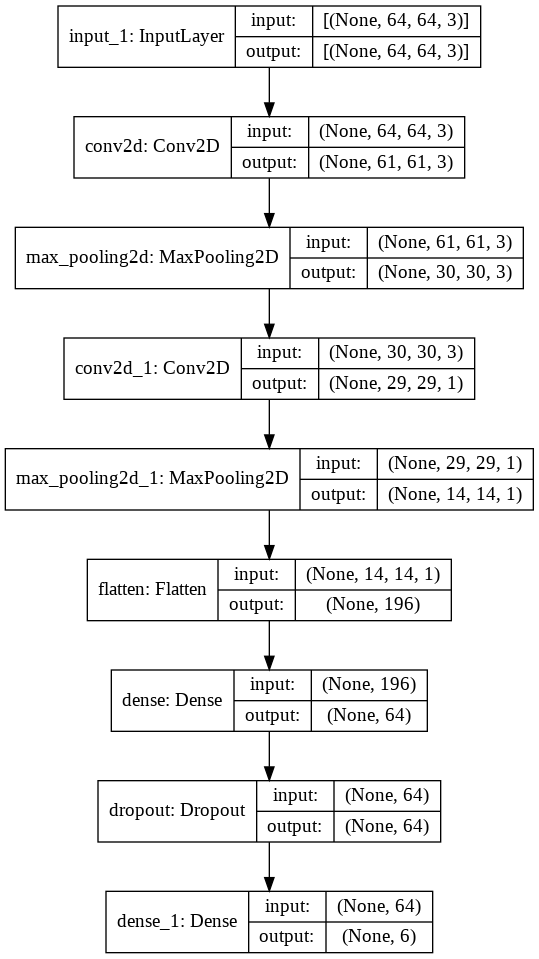

In [49]:
keras.utils.plot_model(model, "cnn_model.png", show_shapes=True)

In [50]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, verbose=1,
                                                  restore_best_weights=True)

#### Fittear

In [51]:
batch_size = 32
epochs = 200
steps_per_epoch = len(X_train) // batch_size

history = model.fit(X_train, y_train[:,0], 
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid[:,0]),
                    callbacks=[early_stopping_cb],
                    verbose=1)

Epoch 1/200
27/27 [==============================] - 3s 80ms/step - loss: 1.8107 - accuracy: 0.1678 - val_loss: 1.7492 - val_accuracy: 0.2731
Epoch 2/200
27/27 [==============================] - 2s 66ms/step - loss: 1.6998 - accuracy: 0.3241 - val_loss: 1.6632 - val_accuracy: 0.3935
Epoch 3/200
27/27 [==============================] - 2s 67ms/step - loss: 1.5641 - accuracy: 0.4051 - val_loss: 1.5384 - val_accuracy: 0.3611
Epoch 4/200
27/27 [==============================] - 2s 67ms/step - loss: 1.3652 - accuracy: 0.5116 - val_loss: 1.3538 - val_accuracy: 0.5185
Epoch 5/200
27/27 [==============================] - 2s 67ms/step - loss: 1.2182 - accuracy: 0.5741 - val_loss: 1.1997 - val_accuracy: 0.5741
Epoch 6/200
27/27 [==============================] - 2s 67ms/step - loss: 1.1165 - accuracy: 0.5984 - val_loss: 1.1491 - val_accuracy: 0.6111
Epoch 7/200
27/27 [==============================] - 2s 67ms/step - loss: 0.9880 - accuracy: 0.6551 - val_loss: 1.0459 - val_accuracy: 0.6574
Epoch 

#### Revisar resultados

16_ANNs_part2.ipynb

In [52]:
early_stopping_cb.stopped_epoch

59

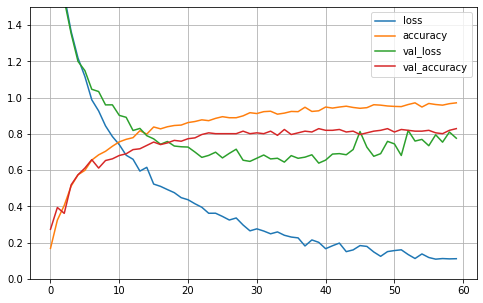

In [53]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

El único tema es que la función de pérdida sobre el conjunto de validación empezó a subir un poco hacia el final. Indicando overfitting.

#### Guardar modelo

In [43]:
# model.save("cnn3_keras_model.h5")
# model.save_weights("cnn3_keras_model.ckpt")

### 2.e Evaluación de las redes

Realice todas las evaluaciones siguientes sobre el conjunto de validación.

* Evalúe ambos modelos ¿qué accuracy obtiene con cada uno?. ¿Es lo que esperaba?
  * Dense: 0.84
  * Convolutional: 0.83
  * Esperaba que el CNN fuera mejor o más fácil de entrenar, y bueno, dependió mucho de como armara el modelo (cantidad filtros, cantidad de unidades, etc.). Asi como quedaron me dio parecido. Con otras configs parecidas la CNN ni entrenaba.

In [44]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
# model_cnn = keras.models.load_model("cnn_keras_model.h5")
model_cnn = keras.models.load_model("cnn3_keras_model.h5")
# model_dnn = keras.models.load_model("dnn_keras_model.h5")
model_dnn = keras.models.load_model("dnn2_keras_model.h5")

In [33]:
model_dnn.evaluate(X_valid, y_valid)

y_proba_dnn = model_dnn.predict(X_valid)
y_pred_dnn = np.argmax(y_proba_dnn, axis=-1)

7/7 [==============================] - 1s 37ms/step - loss: 0.4960 - accuracy: 0.8426


In [34]:
model_cnn.evaluate(X_valid, y_valid)

y_proba_cnn = model_cnn.predict(X_valid)
y_pred_cnn = np.argmax(y_proba_cnn, axis=-1)

7/7 [==============================] - 0s 25ms/step - loss: 0.6383 - accuracy: 0.8287




* Mostrar las predicciones sobre 10 imágenes del conjunto de validación.



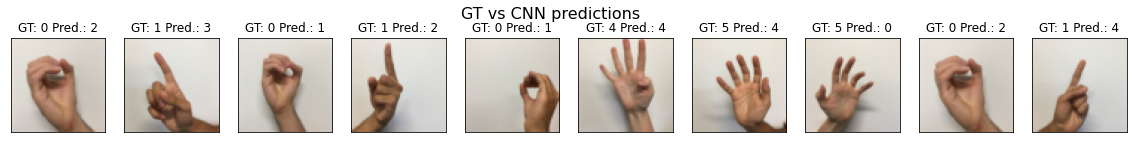

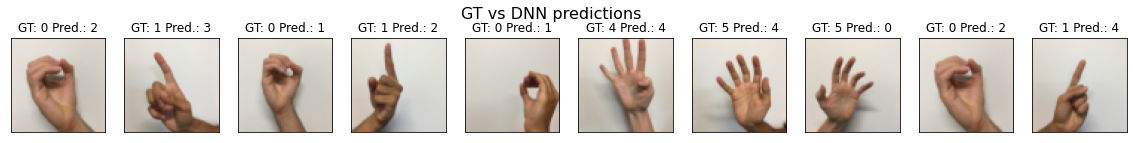

In [35]:
n = 10
idxs = np.random.randint(0, y_test.shape[0], size = n)

plt.figure(figsize=(20, 4))
for i, j in enumerate(idxs):
    ax = plt.subplot(2, n, i + 1)
    plt.title("GT: " + str(y_test[j,0]) + " Pred.: " + str(y_pred_cnn[j]))
    plt.imshow(X_test[j])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle('GT vs CNN predictions', fontsize=16)
plt.show()

plt.figure(figsize=(20, 4))
for i, j in enumerate(idxs):
    ax = plt.subplot(2, n, i + 1)
    plt.title("GT: " + str(y_test[j,0]) + " Pred.: " + str(y_pred_dnn[j]))
    plt.imshow(X_test[j])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle('GT vs DNN predictions', fontsize=16)
plt.show()

No anda re bien pero...

> Flashero



* Obtener las probabilidades de cada clase con `model.predict` y quedarse con la mayor para cada dato. Seperar los casos correctos de los incorrectos y hacer un histograma de las probabilidades para cada uno. Repetir para cada red y comparar.


In [36]:
# Vector para separar hits y misses de cada clasificador
y_pred_cnn_match = (y_valid.flatten() == y_pred_cnn).flatten()
y_pred_dnn_match = (y_valid.flatten() == y_pred_dnn).flatten()

y_pred_cnn_match.shape

(216,)

In [37]:
# Vectores con la probabilidad máxima para cada imagen
y_pred_cnn_max = np.max(y_proba_cnn, axis=1)
y_pred_dnn_max = np.max(y_proba_dnn, axis=1)

print(y_proba_cnn.shape)
y_pred_cnn_max.shape

(216, 6)


(216,)

In [38]:
# Separo hits y misses

y_pred_cnn_max_good = y_pred_cnn_max[y_pred_cnn_match]
y_pred_cnn_max_bad  = y_pred_cnn_max[np.logical_not(y_pred_cnn_match)]

y_pred_dnn_max_good = y_pred_dnn_max[y_pred_dnn_match]
y_pred_dnn_max_bad  = y_pred_dnn_max[np.logical_not(y_pred_dnn_match)]

print(y_pred_cnn_max_good.shape)
print(y_pred_cnn_max_bad.shape)

(179,)
(37,)


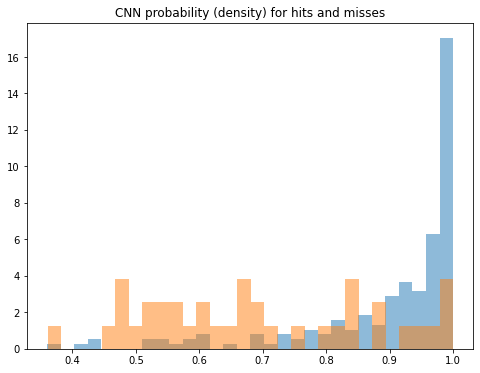

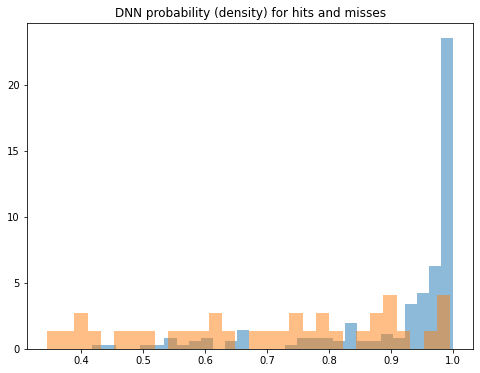

In [39]:
# Grafico la "densidad" porque se ven mejor los errores

n_bins=30

plt.figure(figsize=(8,6))
plt.hist(y_pred_cnn_max_good, bins=n_bins, alpha=0.5, label="Pred. OK",density=True)
plt.hist(y_pred_cnn_max_bad, bins=n_bins, alpha=0.5, label="Pred. BAD",density=True)
plt.title("CNN probability (density) for hits and misses")
plt.show()

plt.figure(figsize=(8,6))
plt.hist(y_pred_dnn_max_good, bins=n_bins, alpha=0.5, label="Pred. OK",density=True)
plt.hist(y_pred_dnn_max_bad, bins=n_bins, alpha=0.5, label="Pred. BAD",density=True)
plt.title("DNN probability (density) for hits and misses")
plt.show()

* Con los resultados anteriores, justifique cuál de los dos modelos es el que funciona mejor para este problema.
  * Ninguna parece equivocarse estando menos "segura" de la clase asignada.
  Es decir, la distribución de activaciones del output toma valores más pequeños cuando se clasifica una seña de forma equivocada, pero ese efecto no es más pronunciado en la CNN que en la fully connected.
  * En teoría las CNNs son mejores para problemas "espaciales" como el de las imágenes, donde los features están localizados en una parte de la imagen (vs. esparcidos). Seguramente sea que a mi no se me ocurrió una definición de CNN relativamente simple y buena para este dataset.
* Evalúelo usando el conjunto de test.
  * Dense: 0.875
  * Convolutional: 0.866

In [41]:
print("CNN")
model_cnn.evaluate(X_test, y_test)

CNN
4/4 [==============================] - 0s 28ms/step - loss: 0.4269 - accuracy: 0.8750


[0.42685699462890625, 0.875]

In [42]:
print("DNN")
model_dnn.evaluate(X_test, y_test)

DNN
4/4 [==============================] - 0s 19ms/step - loss: 0.4003 - accuracy: 0.8667


[0.4003014862537384, 0.8666666746139526]

A la CNN le costaron más los 3 y los 5.

A la DNN le costaron más los 5.


In [40]:
from sklearn.metrics import classification_report

print("CNN")
print(classification_report(y_valid, y_pred_cnn))  # CNN
print("DNN")
print(classification_report(y_valid, y_pred_dnn))  # DNN

CNN
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        40
           1       0.83      0.97      0.90        36
           2       0.82      0.82      0.82        38
           3       0.74      0.81      0.77        31
           4       0.86      0.86      0.86        37
           5       0.80      0.71      0.75        34

    accuracy                           0.83       216
   macro avg       0.83      0.83      0.83       216
weighted avg       0.83      0.83      0.83       216

DNN
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.85      0.94      0.89        36
           2       0.84      0.84      0.84        38
           3       0.88      0.71      0.79        31
           4       0.83      0.78      0.81        37
           5       0.72      0.76      0.74        34

    accuracy                           0.84       216
   macro avg   


Concluimos entonces que con deep learning solo se puede contar hasta 4 con confianza.

> Ahre

**f. Optativo por la gloria.** Usar alguna técnica de preprocesado / reducción de la dimensionalidad con el objetivo de mejorar la performance del algoritmo.

In [ ]:
pass

### 2.x Misc

Quise aumentar el dataset con `ImageDataGenerator` pero no tuve buen resultado: andaba lento y no estaba seguro de que funcionara bien.

In [ ]:
# Not used

# keras.preprocessing.image.ImageDataGenerator

# datagen = keras.preprocessing.image.ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         zca_epsilon=1e-06,  # epsilon for ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         # randomly shift images horizontally (fraction of total width)
#         width_shift_range=0.1,
#         # randomly shift images vertically (fraction of total height)
#         height_shift_range=0.1,
#         shear_range=0.1,  # set range for random shear
#         zoom_range=0.1,  # set range for random zoom
#         channel_shift_range=0.,  # set range for random channel shifts
#         # set mode for filling points outside the input boundaries
#         fill_mode='nearest',
#         cval=0.,  # value used for fill_mode = "constant"
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False,  # randomly flip images
#         # set rescaling factor (applied before any other transformation)
#         rescale=None,
#         # set function that will be applied on each input
#         preprocessing_function=None,
#         # image data format, either "channels_first" or "channels_last"
#         data_format=None,
#         # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0.)

# # Compute quantities required for feature-wise normalization
# # (std, mean, and principal components if ZCA whitening is applied).
# datagen.fit(X_train)

In [ ]:
# batch_size = 32
# epochs = 200
# steps_per_epoch = len(X_train) // batch_size

# model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
#                     epochs=epochs, steps_per_epoch=steps_per_epoch,
#                     validation_data=(X_valid, y_valid),
#                     callbacks=[early_stopping_cb])

Iba a probar con `StandardScaler` pero no tuve tiempo:

In [ ]:
# Not used

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# # X_valid = scaler.transform(X_valid)
# X_test = scaler.transform(X_test)

Probé regularizando los pesos pero no hizo **la** diferencia:

In [ ]:
# from functools import partial

# RegularizedDense = partial(keras.layers.Dense,
#                            activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(0.01))

# n_units = 128

# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=(64,64,3)),
#     RegularizedDense(n_units),
#     RegularizedDense(n_units),
#     RegularizedDense(classes.shape[0], activation="softmax")
# ])

# model.summary()